In [3]:
%pwd
# %cd harzard_prcpt

'/home/daniel/Dev/ms_proj/harzard_prcpt'

In [ ]:
import os
os.environ['FORCE_QWENVL_VIDEO_READER'] = 'decord'

import cv2
from pathlib import Path
from typing import Generator
# from natsort import natsorted

def HarzardPerceptionTestDataLoader(video_folder : str | Path, 
                                    labels_csv_file : str | Path, 
                                    min_hazard_frames : int = 10, 
                                    out_video_folder : str | Path = None, 
                                    separate_videos : bool = False) -> Generator[Path, bool, None]:
    video_folder = Path(video_folder).resolve()
    labels_csv_file = Path(labels_csv_file).resolve()

    # Create the labels dictionary
    labels_dict = {}
    with open(labels_csv_file, 'r') as file:
        for line in file:
            file_name, start_sec, end_sec = line.strip().split(',')
            labels_dict[file_name] = (float(start_sec), float(end_sec))

    # Create output video folder
    if out_video_folder is None:
        out_video_folder = video_folder.parent / "output_videos"
    else:
        out_video_folder = Path(out_video_folder).resolve()
    out_video_folder.mkdir(exist_ok=True)
    print(f"Output videos will be saved to: {out_video_folder}")

    # iterate through video files in the folder with path
    video_files = sorted(os.listdir(video_folder))
    # video_files = natsorted(os.listdir(video_folder))
    for video_file in video_files:
        if video_file.endswith('.mp4') or video_file.endswith('.avi') or video_file.endswith('.webm'):
            video_path = video_folder / video_file
            cap = cv2.VideoCapture(video_path)
            
            if not cap.isOpened():
                print(f"Error opening video file {video_path}")
                continue
            
            fps = cap.get(cv2.CAP_PROP_FPS)
            print(f"FPS for {video_path}: {fps}")
            total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
            duration_sec = total_frames / fps
            
            if video_path.stem in labels_dict:
                start_sec, end_sec = labels_dict[video_path.stem]
                hazard_start_frame = int(start_sec * fps)
                hazard_end_frame = int(end_sec * fps)
                
                print(f"Processing {video_path}:")
                print(f" - Duration: {duration_sec:.2f} seconds")
                print(f" - Hazard frames: {hazard_start_frame} to {hazard_end_frame}")
                print(f" - Hazard seconds: {start_sec} to {end_sec}")
                
                # Get all the frames in the video
                frames = []
                while cap.isOpened():
                    ret, frame = cap.read()
                    if not ret:
                        break
                    frames.append(frame)

                # Create a sliding window - window duration of 5 seconds, stride of 2 seconds
                window_duration_sec = 5 # TODO Hardcoded
                stride_sec = 2 # TODO Hardcoded
                window_size = int(window_duration_sec * fps)
                stride_size = int(stride_sec * fps)
                for start_frame in range(0, total_frames - window_size + 1, stride_size):
                    end_frame = start_frame + window_size
                    window_frames = frames[start_frame:end_frame]

                    # Extract new images added in this window
                    if start_frame == 0:
                        new_images = window_frames.copy()
                    else:
                        # Extract new images added in this window
                        new_images = window_frames[-stride_size:].copy()

                    # Determine if this window contains a hazard
                    # hazard end frame has to be to be to the right of start frame
                    # and hazard start frame has to be to the left of end frame
                    if (start_frame <= (hazard_end_frame - min_hazard_frames)) and (end_frame >= (hazard_start_frame + min_hazard_frames)):
                        label = True  # Hazard present
                    else:
                        label = False  # No hazard
                    
                    # Write window frames to a temporary video file (optional)
                    if separate_videos:
                        temp_video_path = out_video_folder / f"{(label and 'Anom') or 'Norm'}_{video_path.stem}_{start_frame}_{end_frame}.mp4"
                    else:
                        temp_video_path = out_video_folder/ "temp_video_out.mp4"
                    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
                    out = cv2.VideoWriter(temp_video_path, fourcc, fps, (window_frames[0].shape[1], window_frames[0].shape[0]))
                    for frame in window_frames:
                        out.write(frame)
                    out.release()

                    print(f"Window {start_frame}-{end_frame}: Label={label}")

                    yield temp_video_path, label, new_images  # generated video path, label, new images
            else:
                print(f"No labels found for {video_file}")
            
            cap.release()

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns

class Metrics:
    def __init__(self):
        self.reset()

    def reset(self) -> None:
        self.tp = 0
        self.tn = 0
        self.fp = 0
        self.fn = 0
        self.total_time = 0
        self.count = 0

    def update(self, predictions, targets, inference_times) -> None:
        for p, t, inf_time in zip(predictions, targets, inference_times):
            if p == 1 and t == 1:
                self.tp += 1
            elif p == 0 and t == 0:
                self.tn += 1
            elif p == 1 and t == 0:
                self.fp += 1
            elif p == 0 and t == 1:
                self.fn += 1

            self.total_time += inf_time
            self.count += 1

    def compute(self) -> dict:
        accuracy = (self.tp + self.tn) / (self.tp + self.tn + self.fp + self.fn) if (self.tp + self.tn + self.fp + self.fn) > 0 else 0
        precision = self.tp / (self.tp + self.fp) if (self.tp + self.fp) > 0 else 0
        recall = self.tp / (self.tp + self.fn) if (self.tp + self.fn) > 0 else 0
        f1_score = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        avg_inference_time = self.total_time / self.count if self.count > 0 else 0
        return {
            "TP": self.tp,
            "TN": self.tn,
            "FP": self.fp,
            "FN": self.fn,
            "Accuracy": accuracy,
            "Precision": precision,
            "Recall": recall,
            "F1-Score": f1_score,
            "Avg Inference Time": avg_inference_time
        }
    
    def plot_confusion_matrix(self):
        predictions = [1]*self.tp + [0]*self.tn + [1]*self.fp + [0]*self.fn
        targets = [1]*self.tp + [0]*self.tn + [0]*self.fp + [1]*self.fn
        cm = confusion_matrix(targets, predictions)
        plt.figure(figsize=(6, 4))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Anomaly'], yticklabels=['Normal', 'Anomaly'])
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.title('Confusion Matrix')
        plt.show()

In [3]:
# Cosmos FP8 Runner

import torch
import transformers
import qwen_vl_utils
import cv2
import time
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score

class CosmosFP8Runner:
    def __init__(self, user_prompt, max_new_tokens=8):
        # create conversation
        self.user_prompt = user_prompt
        self.max_new_tokens = max_new_tokens

        # Conversation template
        self.conversation = [
            { 
                "role": "user",
                "content": [
                    {
                        "type": "video",
                        "video": None, # to be filled in later
                        "fps": 4, # TODO Input videos is not 4 but 25 - leave it empty
                        "total_pixels": (4*5)*250*250 # 4096 * 30**2, #125 * 250**2 3,686,400 vs 7,812,500
                    },
                    {
                        "type": "text", 
                        "text": self.user_prompt,
                    },
                ],
            }
        ]

        self.load_model("nvidia/Cosmos-Reason1-7B")
        self.warmup_model()

    def run_inference_dataloader(self, dataloader, vid_output, vid_fps, vid_width, vid_height, csv_output_path = None) -> None:
        preds = []
        actuals = []
        result_csv_text = "video_file_name,actual label,predicted label\n"

        # ======== Video for the entire inference ============ 
        # Define the codec and create VideoWriter object
        fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # You can use other codecs as well
        video_writer = cv2.VideoWriter(vid_output, fourcc, vid_fps, (vid_width, vid_height))
        
                    # fourcc = cv2.VideoWriter_fourcc(*'mp4v')
                    # out = cv2.VideoWriter(temp_video_path, fourcc, fps, (window_frames[0].shape[1], window_frames[0].shape[0]))
        # ====================================================

        video_files = sorted(os.listdir("/home/daniel/Dev/ms_proj/harzard_prcpt/output_videos"))
        for i, video_file in enumerate(video_files):
            if not (video_file.endswith('.mp4') or video_file.endswith('.avi') or video_file.endswith('.webm')):
                continue
            if not ("Anom" in video_file or "Norm" in video_file):
                continue

            video_path = Path("/home/daniel/Dev/ms_proj/harzard_prcpt/output_videos") / video_file
            print("\n\n")
            print("="*30)
        
            start_time = time.time()
            result = self.process_and_run_single_video(str(video_path), max_new_tokens=self.max_new_tokens)
            print(f"Inference Time: {time.time() - start_time:.2f}s")        
            # print(result)
            anomaly = self.parse_result(result)
            target = "Anom" in video_file
            actuals.append(target)
            preds.append(anomaly)
            result_csv_text += f"{video_path.name},{int(target)},{int(anomaly)}\n" # video_file_name, actual label, predicted label
            
            print(f"\tActual: {target}, Predicted: {anomaly}")

        #     # Append images to video
        #     images = sample[2]
        #     for img in images:
        #         # Convert PIL Image to OpenCV format
        #         img_cv = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)

        #         # Write prediction and actual on the image
        #         # Put text on rectangle background in the top-center
        #         # Make rectangle green if prediction is correct, red otherwise
        #         if anomaly == sample[1]:
        #             rect_color = (0, 255, 0)  # Green
        #         else:
        #             rect_color = (0, 0, 255)  # Red
        #         cv2.rectangle(img_cv, (vid_width//2 - 400, 30), (vid_width//2 + 400, 140), rect_color, -1)
        #         cv2.putText(
        #             img_cv,
        #             f"Predicted: {anomaly} | Actual: {sample[1]}",
        #             (vid_width//2 - 360, 100),
        #             cv2.FONT_HERSHEY_SIMPLEX,
        #             1.5,
        #             (255, 255, 255),
        #             3,
        #         )
                
        #         # put next text on a transparent black rectangle
                
        #         cv2.putText(img_cv, f"Sample Num: {i+1}", (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

        #         video_writer.write(img_cv)

        # video_writer.release()
        # print(f"Processed video saved at '{vid_output}'")
        
        self.compute_metrics(preds, actuals)
        self.plot_confusion_matrix(preds, actuals)

        metrics = Metrics()
        inference_times = [0.0] * len(preds)  # Placeholder for inference times
        metrics.update(preds, actuals, inference_times)

        # write result_csv_text to a file
        if csv_output_path is None:
            csv_output_path = Path(vid_output).parent / "inference_results.csv"
        with open(csv_output_path, "w") as f:
            f.write("video_file,actual_label,predicted_label\n")
            f.write(result_csv_text)

        return metrics, result_csv_text

    def run_inference_dataloader_old(self, dataloader, vid_output, vid_fps, vid_width, vid_height, csv_output_path = None) -> None:
        preds = []
        actuals = []
        result_csv_text = ""

        # ======== Video for the entire inference ============ 
        # Define the codec and create VideoWriter object
        fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # You can use other codecs as well
        video_writer = cv2.VideoWriter(vid_output, fourcc, vid_fps, (vid_width, vid_height))
        
                    # fourcc = cv2.VideoWriter_fourcc(*'mp4v')
                    # out = cv2.VideoWriter(temp_video_path, fourcc, fps, (window_frames[0].shape[1], window_frames[0].shape[0]))
        # ====================================================
        
        # n_samples = (len(ds) - 50)/20 + 1
        for i, sample in enumerate(dataloader): # dataloader yields (video_path, label, new images)
            video_path = sample[0]
            result = self.process_and_run_single_video(str(video_path), max_new_tokens=self.max_new_tokens)
            # print(result)
            anomaly = self.parse_result(result)
            actuals.append(sample[1])
            preds.append(anomaly)
            result_csv_text += f"{sample[0].name},{int(sample[1])},{int(anomaly)}\n" # video_file_name, actual label, predicted label
            
            print(f"\tActual: {sample[1]}, Predicted: {anomaly}")

            # Append images to video
            images = sample[2]
            for img in images:
                # Convert PIL Image to OpenCV format
                img_cv = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)

                # Write prediction and actual on the image
                # Put text on rectangle background in the top-center
                # Make rectangle green if prediction is correct, red otherwise
                if anomaly == sample[1]:
                    rect_color = (0, 255, 0)  # Green
                else:
                    rect_color = (0, 0, 255)  # Red
                cv2.rectangle(img_cv, (vid_width//2 - 400, 30), (vid_width//2 + 400, 140), rect_color, -1)
                cv2.putText(
                    img_cv,
                    f"Predicted: {anomaly} | Actual: {sample[1]}",
                    (vid_width//2 - 360, 100),
                    cv2.FONT_HERSHEY_SIMPLEX,
                    1.5,
                    (255, 255, 255),
                    3,
                )
                
                # put next text on a transparent black rectangle
                
                cv2.putText(img_cv, f"Sample Num: {i+1}", (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

                video_writer.write(img_cv)

        video_writer.release()
        print(f"Processed video saved at '{vid_output}'")
        
        self.compute_metrics(preds, actuals)
        self.plot_confusion_matrix(preds, actuals)

        metrics = Metrics()
        inference_times = [0.0] * len(preds)  # Placeholder for inference times
        metrics.update(preds, actuals, inference_times)

        # write result_csv_text to a file
        if csv_output_path is None:
            csv_output_path = Path(vid_output).parent / "inference_results.csv"
        with open(csv_output_path, "w") as f:
            f.write("video_file,actual_label,predicted_label\n")
            f.write(result_csv_text)

        return metrics, result_csv_text

    def load_model(self, model_name: str) -> None:
        print("🔧 Loading and compiling model... This may take a few seconds.")
        start = time.time()

        bnb_config = transformers.BitsAndBytesConfig(load_in_8bit=True)
        self.model = transformers.Qwen2_5_VLForConditionalGeneration.from_pretrained(
            model_name,
            dtype=torch.bfloat16,
            quantization_config=bnb_config,
            # attn_implementation="flash_attention_2",
            device_map="auto",
            # local_files_only=True
        ).eval()

        self.processor = transformers.AutoProcessor.from_pretrained(model_name) #, local_files_only=True)
        self.model.gradient_checkpointing_disable()
        torch.set_float32_matmul_precision("high")
        self.model = torch.compile(self.model)#, mode="reduce-overhead")

        print(f"✅ Model ready in {time.time() - start:.2f}s\n")
        # return model, processor

    def warmup_model(self) -> None:
        if self.model is None or self.processor is None:
            raise ValueError("Model and processor must be loaded before warmup.")

        print("🔥 Warming up model (compiling kernels)...")
        dummy_conv = [{"role": "user", "content": [{"type": "text", "text": "Is this scene safe?"}]}]
        text = self.processor.apply_chat_template(dummy_conv, tokenize=False, add_generation_prompt=True)
        inputs = self.processor(text=[text], return_tensors="pt").to(self.model.device)
        with torch.inference_mode():
            _ = self.model.generate(**inputs, max_new_tokens=7)
        torch.cuda.synchronize()
        print("✅ Warmup complete.\n")

    def parse_result(self, raw_output: str) -> bool:
        out = raw_output.lower()
        if "anomaly" in out:
            return True
        elif "normal" in out:
            return False
        else:
            raise ValueError(f"Unexpected model output: {raw_output}")
    
    def process_and_run_single_video(self, video_path, max_new_tokens=7):
        print(f"Cosmos processing video: {video_path}")

        # Insert video path into conversation
        self.conversation[0]["content"][0]["video"] = str(video_path)

        text = self.processor.apply_chat_template(
            self.conversation, tokenize=False, add_generation_prompt=True
        )
        image_inputs, video_inputs = qwen_vl_utils.process_vision_info(self.conversation)
        inputs = self.processor(
            text=[text],
            images=image_inputs,
            videos=video_inputs,
            padding=True,
            return_tensors="pt",
        )
        inputs = inputs.to(self.model.device)

        with torch.inference_mode():
            # generated_ids = self.model.generate(**inputs, max_new_tokens=max_new_tokens, do_sample=False) # Added do_sample=False for deterministic output
            output = self.model.generate(**inputs, max_new_tokens=max_new_tokens, do_sample=False) # Added do_sample=False for deterministic output

        # generated_ids_trimmed = [
        #     out_ids[len(in_ids) :]
        #     for in_ids, out_ids in zip(inputs.input_ids, generated_ids, strict=False)
        # ]
        # output_text = self.processor.batch_decode(
        #     generated_ids_trimmed,
        #     skip_special_tokens=True,
        #     clean_up_tokenization_spaces=False,
        # )

        new_tokens = output[:, inputs.input_ids.shape[1]:]
        output_text = self.processor.batch_decode(new_tokens, skip_special_tokens=True)[0].strip()

        print(f"Cosmos output: {output_text}")
        return output_text
    
    def compute_metrics(self, predictions, actuals):
        # Accuracy calculation
        correct = sum(p == a for p, a in zip(predictions, actuals))
        accuracy = correct / len(actuals) if actuals else 0
        print("="*30)
        print(f"Accuracy: {accuracy * 100:.2f}%")

        # Computer precision, recall, F1-score
        precision = precision_score(actuals, predictions)
        recall = recall_score(actuals, predictions)
        f1 = f1_score(actuals, predictions)
        print("="*30)
        print(f"Precision: {precision * 100:.2f}%")
        print(f"Recall: {recall * 100:.2f}%")
        print(f"F1-score: {f1 * 100:.2f}%")

        # True Positives, False Positives, True Negatives, False Negatives
        tp = sum((p == 1) and (a == 1) for p, a in zip(predictions, actuals))
        fp = sum((p == 1) and (a == 0) for p, a in zip(predictions, actuals))
        tn = sum((p == 0) and (a == 0) for p, a in zip(predictions, actuals))
        fn = sum((p == 0) and (a == 1) for p, a in zip(predictions, actuals))
        print("="*30)
        print(f"True Positives: {tp}")
        print(f"False Positives: {fp}")
        print(f"True Negatives: {tn}")
        print(f"False Negatives: {fn}")

    def plot_confusion_matrix(self, predictions, actuals):
        # cm = confusion_matrix(actuals, predictions)
        # plt.figure(figsize=(6, 4))
        # sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Anomaly'], yticklabels=['Normal', 'Anomaly'])
        # plt.xlabel('Predicted Label')
        # plt.ylabel('True Label')
        # plt.title('Confusion Matrix')
        # plt.show()

        
        # tp = sum((p == 1) and (a == 1) for p, a in zip(predictions, actuals))
        # fp = sum((p == 1) and (a == 0) for p, a in zip(predictions, actuals))
        # tn = sum((p == 0) and (a == 0) for p, a in zip(predictions, actuals))
        # fn = sum((p == 0) and (a == 1) for p, a in zip(predictions, actuals))
        # cm = np.array([[tn, fp], [fn, tp]])
        # disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Normal", "Anomaly"])
        # disp.plot(cmap=plt.cm.Blues)
        # plt.title("Confusion Matrix")
        # plt.show()
        pass

    

In [4]:
# Run Inference on Hazard Perception Test Data Loader using Cosmos FP8 Runner

user_prompt = (
            "You are an autonomous driving safety expert analyzing this video for EXTERNAL ANOMALIES that may impact safe AV operation.\n\n"
            "<think>\n"
            "Focus on:\n"
            "- Obstacles, pedestrians, or vehicles violating rules\n"
            "- Roadwork, blocked lanes, poor visibility, or hazards\n"
            "- Reflections, shadows, or false visual cues confusing perception\n"
            "</think>\n\n"
            "<answer>\n"
            "Is there any external anomaly in this video? Reply with exactly one of the following:\n"
            "Classification: Anomaly — if any obstacle, obstruction, or unsafe condition is visible.\n"
            "Classification: Normal — if no anomaly or obstruction is visible.\n"
            "</answer>"
        )

runner = CosmosFP8Runner(user_prompt, max_new_tokens=7)

🔧 Loading and compiling model... This may take a few seconds.


Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

The image processor of type `Qwen2VLImageProcessor` is now loaded as a fast processor by default, even if the model checkpoint was saved with a slow processor. This is a breaking change and may produce slightly different outputs. To continue using the slow processor, instantiate this class with `use_fast=False`. Note that this behavior will be extended to all models in a future release.
/home/daniel/Dev/ms_proj/cosmos-reason1/.venv/lib/python3.10/site-packages/torch/__init__.py:1617: UserWarning: Please use the new API settings to control TF32 behavior, such as torch.backends.cudnn.conv.fp32_precision = 'tf32' or torch.backends.cuda.matmul.fp32_precision = 'ieee'. Old settings, e.g, torch.backends.cuda.matmul.allow_tf32 = True, torch.backends.cudnn.allow_tf32 = True, allowTF32CuDNN() and allowTF32CuBLAS() will be deprecated after Pytorch 2.9. Please see https://pytorch.org/docs/main/notes/cuda.html#tensorfloat-32-tf32-on-ampere-and-later-devices (Triggered internally at /pytorch/aten/s

✅ Model ready in 43.82s

🔥 Warming up model (compiling kernels)...


/home/daniel/Dev/ms_proj/cosmos-reason1/.venv/lib/python3.10/site-packages/bitsandbytes/autograd/_functions.py:181: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


✅ Warmup complete.



In [5]:
# Create dataloader
dataloader = HarzardPerceptionTestDataLoader("./videos", "labels.csv", min_hazard_frames=10, out_video_folder="./output_videos", separate_videos=True)

# Extract video fps, width, height from first video in dataloader
first_video_path, _, _ = next(dataloader)
cap = cv2.VideoCapture(first_video_path)
vid_fps = cap.get(cv2.CAP_PROP_FPS)
vid_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
vid_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
cap.release()
print(f"\n\nVideo FPS: {vid_fps}, Width: {vid_width}, Height: {vid_height}")


Output videos will be saved to: /home/daniel/Dev/ms_proj/harzard_prcpt/output_videos
FPS for /home/daniel/Dev/ms_proj/harzard_prcpt/videos/3.webm: 25.0
Processing /home/daniel/Dev/ms_proj/harzard_prcpt/videos/3.webm:
 - Duration: 56.84 seconds
 - Hazard frames: 675 to 1375
 - Hazard seconds: 27.0 to 55.0
Window 0-125: Label=False


Video FPS: 25.0, Width: 1280, Height: 720


In [9]:
# dataloader = HarzardPerceptionTestDataLoader("./videos", "labels.csv", min_hazard_frames=10, out_video_folder="./output_videos", separate_videos=True)
# list(dataloader)  # exhaust generator to reset it

In [10]:
# reset dataloader
dataloader = HarzardPerceptionTestDataLoader("./videos", "labels.csv", min_hazard_frames=10, out_video_folder="./output_videos", separate_videos=True)

output_root = Path("./output_videos")
output_root.mkdir(exist_ok=True)

# run inference
metrics, csv_output = runner.run_inference_dataloader(
    dataloader,
    vid_output=output_root / "inference_results.mp4",
    vid_fps=vid_fps,
    vid_width=vid_width,
    vid_height=vid_height,
)




Cosmos processing video: /home/daniel/Dev/ms_proj/harzard_prcpt/output_videos/Anom_10_450_575.mp4


qwen-vl-utils using decord to read video.
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Cosmos output: Classification: Anomaly

The red
Inference Time: 5.49s
	Actual: True, Predicted: True



Cosmos processing video: /home/daniel/Dev/ms_proj/harzard_prcpt/output_videos/Anom_10_500_625.mp4
Cosmos output: Classification: Anomaly

The red
Inference Time: 4.38s
	Actual: True, Predicted: True



Cosmos processing video: /home/daniel/Dev/ms_proj/harzard_prcpt/output_videos/Anom_10_550_675.mp4
Cosmos output: <answer>Classification: Anomaly
Inference Time: 4.58s
	Actual: True, Predicted: True



Cosmos processing video: /home/daniel/Dev/ms_proj/harzard_prcpt/output_videos/Anom_10_600_725.mp4
Cosmos output: <answer>
Classification: Anomaly
Inference Time: 4.55s
	Actual: True, Predicted: True



Cosmos processing video: /home/daniel/Dev/ms_proj/harzard_prcpt/output_videos/Anom_10_650_775.mp4
Cosmos output: Classification: Anomaly

The road
Inference Time: 4.81s
	Actual: True, Predicted: True



Cosmos processing video: /home/daniel/Dev/ms_proj/harzard_prcpt/output_videos/Anom_1_400

{'TP': 66, 'TN': 63, 'FP': 117, 'FN': 0, 'Accuracy': 0.524390243902439, 'Precision': 0.36065573770491804, 'Recall': 1.0, 'F1-Score': 0.5301204819277109, 'Avg Inference Time': 0.0}


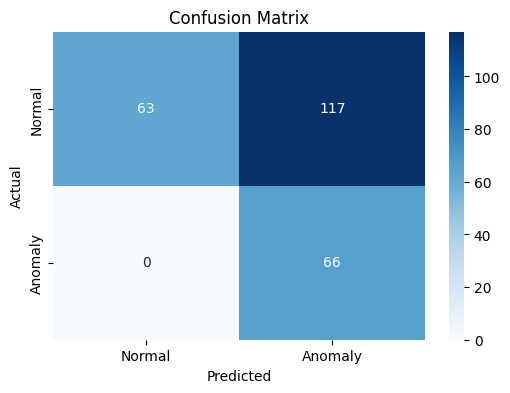

In [11]:
print(metrics.compute())
metrics.plot_confusion_matrix()

In [6]:

def run_inference_dataloader_old(self, dataloader, vid_output, vid_fps, vid_width, vid_height, csv_output_path = None, cv_convert_RGB2BGR = False) -> None:
    preds = []
    actuals = []
    inference_times = []
    result_csv_text = "File Name,Actual Label,Predicted Label\n"

    # ======== Video for the entire inference ============ 
    # Define the codec and create VideoWriter object
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # You can use other codecs as well
    video_writer = cv2.VideoWriter(vid_output, fourcc, vid_fps, (vid_width, vid_height))
    # ====================================================
    
    # n_samples = (len(ds) - 50)/20 + 1
    for i, sample in enumerate(dataloader): # dataloader yields (video_path, label, new images)
        video_path = str(sample[0])
        if not (video_path.endswith('.mp4') or video_path.endswith('.avi') or video_path.endswith('.webm')):
                continue
        
        print("\n\n")
        print("="*30)
        
        # Run inference on video
        start_time = time.time()
        result = self.process_and_run_single_video(str(video_path), max_new_tokens=self.max_new_tokens)
        end_time = time.time()
        inference_times.append(end_time - start_time)
        print(f"\tInference Time: {time.time() - start_time:.2f}s")        

        anomaly = self.parse_result(result)
        actuals.append(sample[1])
        preds.append(anomaly)
        result_csv_text += f"{sample[0].name},{int(sample[1])},{int(anomaly)}\n" # video_file_name, actual label, predicted label
        
        print(f"\tActual: {sample[1]}, Predicted: {anomaly}")

        # Append images to video
        images = sample[2]
        for img in images:
            # Convert PIL Image to OpenCV format
            if cv_convert_RGB2BGR:
                img_cv = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)
            else:
                img_cv = img

            # Write prediction and actual on the image
            # Put text on rectangle background in the top-center
            # Make rectangle green if prediction is correct, red otherwise
            # if anomaly == sample[1]:
            if not anomaly:
                rect_color = (0, 255, 0)  # Green
            else:
                rect_color = (0, 0, 255)  # Red
            cv2.rectangle(img_cv, (vid_width//2 - 250, 30), (vid_width//2 + 250, 110), rect_color, -1)
            # make text box same as rectangle and align text to center
            cv2.putText(
                img_cv,
                f"Predicted: {'Anomaly' if anomaly else 'Normal'}",
                (vid_width//2 - 220, 85),
                cv2.FONT_HERSHEY_SIMPLEX,
                1.5,
                (255, 255, 255),
                3,
            )
            
            # put next text on a transparent black rectangle
            cv2.rectangle(img_cv, (0, vid_height - 90), (350, vid_height), (0, 0, 0), -1)
            
            # Actual label
            cv2.putText(img_cv, f"Actual: {'Anomaly' if sample[1] else 'Normal'}", 
                        (20, vid_height - 50), 
                        cv2.FONT_HERSHEY_SIMPLEX, 
                        0.7, 
                        (0, 0, 255) if sample[1] else (0, 255, 0),
                        2)
            # Sample time range
            new_imgs_duration_sec = len(images) / vid_fps # we assume all samples have same length
            cv2.putText(img_cv, f"Sample {i+1} ({i*new_imgs_duration_sec} - {(i)*new_imgs_duration_sec + 5}s)", # hardcoded... dataloader should provide this info
                        (20, vid_height - 20), 
                        cv2.FONT_HERSHEY_SIMPLEX, 
                        0.7, (0, 255, 0), 2)

            video_writer.write(img_cv)

    video_writer.release()
    print(f"\tProcessed video saved at '{vid_output}'")
    
    self.compute_metrics(preds, actuals)
    self.plot_confusion_matrix(preds, actuals)

    metrics = Metrics()
    metrics.update(preds, actuals, inference_times)

    # write result_csv_text to a file
    if csv_output_path is None:
        csv_output_path = Path(vid_output).parent / "inference_results.csv"
    with open(csv_output_path, "w") as f:
        f.write(result_csv_text)

    return metrics, result_csv_text


In [7]:
# reset dataloader
dataloader = HarzardPerceptionTestDataLoader("./videos", "labels.csv", min_hazard_frames=10, out_video_folder="./output_videos", separate_videos=True)

output_root = Path("./output_videos")
output_root.mkdir(exist_ok=True)

# run inference
metrics, csv_output = run_inference_dataloader_old(runner,
    dataloader,
    vid_output=output_root / "inference_results.mp4",
    vid_fps=vid_fps,
    vid_width=vid_width,
    vid_height=vid_height,
    cv_convert_RGB2BGR=False
)

Output videos will be saved to: /home/daniel/Dev/ms_proj/harzard_prcpt/output_videos
FPS for /home/daniel/Dev/ms_proj/harzard_prcpt/videos/3.webm: 25.0
Processing /home/daniel/Dev/ms_proj/harzard_prcpt/videos/3.webm:
 - Duration: 56.84 seconds
 - Hazard frames: 675 to 1375
 - Hazard seconds: 27.0 to 55.0
Window 0-125: Label=False



Cosmos processing video: /home/daniel/Dev/ms_proj/harzard_prcpt/output_videos/Norm_3_0_125.mp4


qwen-vl-utils using decord to read video.
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Cosmos output: Classification: Normal
	Inference Time: 5.49s
	Actual: False, Predicted: False
Window 50-175: Label=False



Cosmos processing video: /home/daniel/Dev/ms_proj/harzard_prcpt/output_videos/Norm_3_50_175.mp4
Cosmos output: Classification: Normal

The video shows
	Inference Time: 2.40s
	Actual: False, Predicted: False
Window 100-225: Label=False



Cosmos processing video: /home/daniel/Dev/ms_proj/harzard_prcpt/output_videos/Norm_3_100_225.mp4
Cosmos output: Classification: Normal
	Inference Time: 1.82s
	Actual: False, Predicted: False
Window 150-275: Label=False



Cosmos processing video: /home/daniel/Dev/ms_proj/harzard_prcpt/output_videos/Norm_3_150_275.mp4
Cosmos output: Classification: Normal

The video shows
	Inference Time: 2.29s
	Actual: False, Predicted: False
Window 200-325: Label=False



Cosmos processing video: /home/daniel/Dev/ms_proj/harzard_prcpt/output_videos/Norm_3_200_325.mp4
Cosmos output: Classification: Normal

The video shows
	Inference Time: 2.12s
	A

{'TP': 61, 'TN': 77, 'FP': 103, 'FN': 5, 'Accuracy': 0.5609756097560976, 'Precision': 0.3719512195121951, 'Recall': 0.9242424242424242, 'F1-Score': 0.5304347826086956, 'Avg Inference Time': 2.5028135262853732}


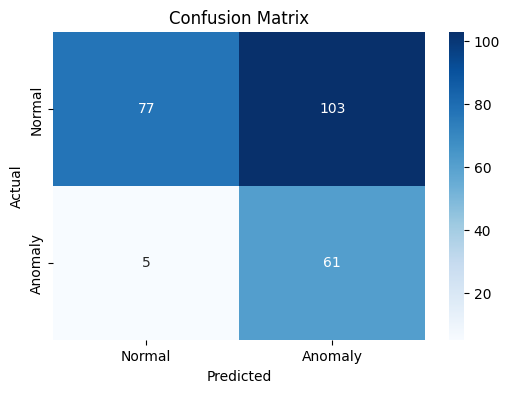

In [46]:
print(metrics.compute())
metrics.plot_confusion_matrix()

In [12]:
# # run inference for all videos in /home/daniel/Dev/ms_proj/harzard_prcpt/output_videos

# # downsample token budget:
# # downsample fps
# # downscale max_tokens
# # downscale target resolution



# video_files = sorted(os.listdir("/home/daniel/Dev/ms_proj/harzard_prcpt/output_videos"))

# # change video total pixels
# fps = 4
# max_tokens = 7
# scale_factor = 2  # downscale by factor of 2
# target_resolution = 250*250 # 1280*720/(scale_factor**2)
# duration_sec = 5
# total_pixels = (fps * duration_sec) * target_resolution

# runner.conversation[0]["content"][0]["total_pixels"] = int(total_pixels)
# print(f"Updated total pixels to: {runner.conversation[0]['content'][0]['total_pixels']}")

# for video_file in video_files:
#     if video_file.endswith('.mp4') or video_file.endswith('.avi') or video_file.endswith('.webm'):
#         video_path = Path("/home/daniel/Dev/ms_proj/harzard_prcpt/output_videos") / video_file
        
#         start_time = time.time()
#         text = runner.process_and_run_single_video(str(video_path), max_new_tokens=max_tokens)
#         print(f"Inference Time: {time.time() - start_time:.2f}s")
#         # print(f"Video: {video_file}, Result: {text}")
        



# # runner.process_and_run_single_video("/home/daniel/Dev/ms_proj/stu_dataset/output_video.mp4")

Hello Professor,

Hope my email meets you well.

I received an email from Ginell Tait (to course assistants) to submit an application on LinkedIn if interested in continuiing with a GA role for the Spring semester. I have copied the email below.

I wanted to confirm with you if I should also be submitting this before proceeding.

"""
---------- Forwarded message ---------
From: Ginell Tait <gt2509@nyu.edu>
Date: Fri, Dec 5, 2025 at 10:51 AM
Subject: Reapplying for Course Assistant Role Spring 2026 Term
To:


Good morning and Happy Friday!

Please read this email carefully:


If you plan to continue as a Course Assistant for the Spring 2026 term, please reapply for the Course Assistant role on Handshake at your earliest convenience.

If your current professor is not teaching in Spring 2026 and you wish to work as a TA for another professor, please still complete the same Handshake application.

Job ID: 10548774

Please also keep an eye out next week for emails from Shared Services (like previously).
Be sure to complete every step, including uploading your signed offer letter, to avoid delays.

If you will be traveling during the holiday, please submit your Wasserman form before you leave, if possible. This will ensure there are no delays to your start date.

If you have any questions, please don’t hesitate to reach out.

Best,
Ginell
"""

Best regards,
Daniel